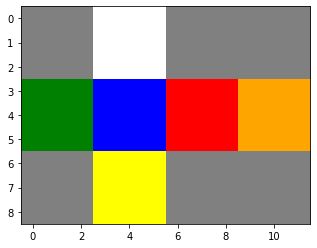

100%|██████████| 20/20 [01:53<00:00,  5.69s/it]


In [3]:
import time
import argparse
import random
import logging
import datetime
import collections
import csv

from tqdm import tqdm
import seaborn as sns
import matplotlib.pylab as plt
import torch
from IPython import display
import matplotlib.pyplot as plt

from libcube import cubes
from libcube import model
from libcube import mcts
import matplotlib as mpl
import numpy as np
%matplotlib inline
log = logging.getLogger("solver")


DataPoint = collections.namedtuple("DataPoint", field_names=(
    'start_dt', 'stop_dt', 'duration', 'depth', 'scramble', 'is_solved', 'solve_steps', 'sol_len_naive', 'sol_len_bfs',
    'depth_max', 'depth_mean'
))


DEFAULT_MAX_SECONDS = 60
PLOT_MAX_DEPTHS = 50
PLOT_TASKS = 20


def generate_task(env, depth):
    res = []
    prev_a = None
    for _ in range(depth):
        a = env.sample_action(prev_action=prev_a)
        res.append(a.value)
        prev_a = a
    return res


def gather_data(cube_env, net, max_seconds, max_steps, max_depth, samples_per_depth, batch_size, device):

    result = []
    try:
        solved_count = 0
        for task_idx in tqdm(range(samples_per_depth)):
            start_dt = datetime.datetime.utcnow()
            task = generate_task(cube_env, 5)
            tree, solution = solve_task(cube_env, task, net, cube_idx=task_idx, max_seconds=max_seconds,
                                        max_steps=max_steps, device=device,batch_size=batch_size)
            is_solved = solution is not None
            stop_dt = datetime.datetime.utcnow()
            duration = (stop_dt - start_dt).total_seconds()
            scramble = " ".join(map(str, task))
            tree_depth_stats = tree.get_depth_stats()
            sol_len_naive, sol_len_bfs = -1, -1
            if is_solved:
                sol_len_naive = len(solution)
                sol_len_bfs = len(tree.find_solution())
            data_point = DataPoint(start_dt=start_dt, stop_dt=stop_dt, duration=duration, depth=5,
                                   scramble=scramble, is_solved=is_solved, solve_steps=len(tree),
                                   sol_len_naive=sol_len_naive, sol_len_bfs=sol_len_bfs,
                                   depth_max=tree_depth_stats['max'], depth_mean=tree_depth_stats['mean'])
            result.append(data_point)
            if is_solved:
                solved_count += 1
    except KeyboardInterrupt:
        log.info("Interrupt received, got %d data samples, use them", len(result))
    return result


def save_output(data, output_file):
    with open(output_file, "wt", encoding='utf-8') as fd:
        writer = csv.writer(fd)
        writer.writerow(['start_dt', 'stop_dt', 'duration', 'depth', 'scramble', 'is_solved', 'solve_steps',
                         'sol_len_naive', 'sol_len_bfs', 'tree_depth_max', 'tree_depth_mean'])
        for dp in data:
            writer.writerow([
                dp.start_dt.isoformat(),
                dp.stop_dt.isoformat(),
                dp.duration,
                dp.depth,
                dp.scramble,
                int(dp.is_solved),
                dp.solve_steps,
                dp.sol_len_naive,
                dp.sol_len_bfs,
                dp.depth_max,
                dp.depth_mean
            ])


def solve_task(env, task, net, cube_idx=None, max_seconds=DEFAULT_MAX_SECONDS, max_steps=None,
               device=torch.device("cpu"), batch_size=1):
    log_prefix = "" if cube_idx is None else "cube %d: " % cube_idx
    global solutions
    log.info("%sGot task %s, solving...", log_prefix, task)
    cube_state = env.scramble(map(env.action_enum, task))
    tree = mcts.MCTS(env, cube_state, net, device=device)
    step_no = 0
    ts = time.time()

    while True:
        if batch_size > 1:
            solution = tree.search_batch(batch_size)
        else:
            solution = tree.search()
        if solution:
            #tree.dump_solution(solution)
            solutions = tree.get_solution(solution)
            show_rubic(solutions)
            return tree, solution
        step_no += 1
        if max_steps is not None:
            if step_no > max_steps:
                return tree, None
        elif time.time() - ts > max_seconds:
            return tree, None
        
def show_rubic(solutions):
    x = np.zeros((9,12))
    color_dict = {'G':1,'B':2,'W':3,'O':4,'R':5,'Y':6}
    plt.figure()
    
    colors = ['grey', 'green','blue', 'white', 'orange','red','yellow'] 
    cmap = mpl.colors.ListedColormap(colors)
    for solution in solutions:
        for color in range(len(solution.top)):
            x[0+color%3,3+color//3] = color_dict[solution.top[color]]
        for color in range(len(solution.bottom)):
            x[6+color%3,3+color//3] = color_dict[solution.bottom[color]]
        for color in range(len(solution.left)):
            x[3+color%3,0+color//3] = color_dict[solution.left[color]]
        for color in range(len(solution.right)):
            x[3+color%3,3+color//3] = color_dict[solution.right[color]]
        for color in range(len(solution.front)):
            x[3+color%3,6+color//3] = color_dict[solution.front[color]]
        for color in range(len(solution.back)):
            x[3+color%3,9+color//3] = color_dict[solution.back[color]]
        plt.cla() 
        display.clear_output(wait=True)
        plt.imshow(x,cmap=cmap)
        plt.pause(0.03) 
    plt.show()

def produce_plots(data, prefix, max_seconds, max_steps):
    data_solved = [(dp.depth, int(dp.is_solved)) for dp in data]
    data_steps = [(dp.depth, dp.solve_steps) for dp in data if dp.is_solved]

    if max_steps is not None:
        suffix = "(steps limit %d)" % max_steps
    else:
        suffix = "(time limit %d secs)" % max_seconds

    sns.set()
    d, v = zip(*data_solved)
    plot = sns.lineplot(d, v)
    plot.set_title("Solve ratio per depth %s" % suffix)
    plot.get_figure().savefig(prefix + "-solve_vs_depth.png")

    plt.clf()
    d, v = zip(*data_steps)
    plot = sns.lineplot(d, v)
    plot.set_title("Steps to solve per depth %s" % suffix)
    plot.get_figure().savefig(prefix + "-steps_vs_depth.png")


if __name__ == "__main__":
    logging.basicConfig(format="%(asctime)-15s %(levelname)s %(message)s", level=logging.INFO)
    parser = argparse.ArgumentParser()
    parser.add_argument("-e", "--env", default='cube3x3')
    parser.add_argument("-m", "--model", default='origin.dat')
    parser.add_argument("--max-time", type=int, default=DEFAULT_MAX_SECONDS,
                        help="Limit in seconds for each task, default=%s" % DEFAULT_MAX_SECONDS)
    parser.add_argument("--max-steps", type=int,default=30000)
    parser.add_argument("--max-depth", type=int, default=PLOT_MAX_DEPTHS,
                        help="Maximum depth for plots and data, default=%s" % PLOT_MAX_DEPTHS)
    parser.add_argument("--samples", type=int, default=PLOT_TASKS,
                        help="Count of tests of each depth, default=%s" % PLOT_TASKS)
    parser.add_argument("-b", "--batch", type=int, default=1, help="Batch size to use during the search, default=1")
    parser.add_argument("--cuda", default=False, action="store_true", help="Enable cuda")
    parser.add_argument("--seed", type=int, default=42, help="Seed to use, if zero, no seed used. default=42")
    parser.add_argument("--output", default ='origin.csv' )
    parser.add_argument("-r", "--random", metavar="DEPTH", type=int, help="Generate random scramble of given depth")
    parser.add_argument("-p", "--perm", help="Permutation in form of actions list separated by comma")
    parser.add_argument("-i", "--input", help="Text file with permutations to read cubes to solve, "
                                             "possibly produced by gen_cubes.py")
    parser.add_argument("--plot", metavar="PREFIX", help="Produce plots of model solve accuracy")
#     group = parser.add_mutually_exclusive_group(required=True)
#     group.add_argument("-i", "--input", help="Text file with permutations to read cubes to solve, "
#                                              "possibly produced by gen_cubes.py")
#     group.add_argument("-p", "--perm", help="Permutation in form of actions list separated by comma")
#     group.add_argument("-r", "--random", metavar="DEPTH", type=int, help="Generate random scramble of given depth")
#     group.add_argument("--plot", metavar="PREFIX", help="Produce plots of model solve accuracy")

    args = parser.parse_args([])

    if args.seed:
        random.seed(args.seed)
    device = torch.device("cuda" if args.cuda else "cpu")

    cube_env = cubes.get(args.env)
    log.info("Using environment %s", cube_env)
    assert isinstance(cube_env, cubes.CubeEnv)            

    #cube_env.render()
    net = model.Net(cube_env.encoded_shape, len(cube_env.action_enum)).to(device)
    net.load_state_dict(torch.load(args.model, map_location=lambda storage, loc: storage))
    net.eval()
    log.info("Network loaded from %s", args.model)


    data = gather_data(cube_env, net, args.max_time, args.max_steps, args.max_depth, args.samples,
                       args.batch, device)
